##We begin by reading in the data and merging the training set with the outcome variable which we want to predict.

In [0]:
# import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from google.colab import files
from sklearn.base import clone 
from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV

In [0]:
# load data (saved to my github account)
url = "https://raw.githubusercontent.com/Matiki/Springboard/master/Capstone_1/data/trainvalues.csv"
train = pd.read_csv(url)

url = "https://raw.githubusercontent.com/Matiki/Springboard/master/Capstone_1/data/trainlabels.csv"
trainlabels = pd.read_csv(url)

url = "https://raw.githubusercontent.com/Matiki/Springboard/master/Capstone_1/data/testvalues.csv"
test = pd.read_csv(url)

In [170]:
# merge data frames
full = pd.merge(train, trainlabels, on = "id")
full.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


##Now that we have the data, we'll take a quick look to get more information about the data types.

In [171]:
# look at the data types
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
r

##Most variables are categorical, with only a few numerical variables. We'll take a look at those next. 

In [172]:
# take a look at the numerical variables
numvar = full.loc[:, ["amount_tsh", "gps_height", "num_private", "longitude", 
                      "latitude", "population", "construction_year"]]
numvar.describe()

,amount_tsh,gps_height,num_private,longitude,latitude,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000
mean,317.650385,668.297239,0.474141,34.077427,-5.706033e+00,179.909983,1300.652475
std,2997.574558,693.116350,12.236230,6.567432,2.946019e+00,471.482176,951.620547
min,0.000000,-90.000000,0.000000,0.000000,-1.164944e+01,0.000000,0.000000
25%,0.000000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,0.000000
50%,0.000000,369.000000,0.000000,34.908743,-5.021597e+00,25.000000,1986.000000
75%,20.000000,1319.250000,0.000000,37.178387,-3.326156e+00,215.000000,2004.000000
max,350000.000000,2770.000000,1776.000000,40.345193,-2.000000e-08,30500.000000,2013.000000


##It seems there are some irregularities that don't make much sense. Many of these variables contain zero values, which must indicate missing data. For example, a zero value for 'longitude' would indicate a location on the prime meridian, which is nowhere near Tanzania, where the data were collected. Similarly, a 'population' or 'construction_year' value of zero would not make sense either. However, 'gps_height', which indicates the altitude of the well, may take zero values if the well is located at sea level. Next we'll look at how many entries have zero values to get a better idea of much data are missing

In [173]:
# take a look at how many zeros are in the data
print("amount_tsh entries equal to zero: ", np.sum(full.amount_tsh == 0))
print("gps_height entries equal to zero: ", np.sum(full.gps_height == 0))
print("num_private entries equal to zero: ", np.sum(full.num_private == 0))
print("latitude entries equal to zero: ", np.sum(full.latitude == 0))
print("longitude entries equal to zero: ", np.sum(full.longitude == 0))
print("population entries equal to zero: ", np.sum(full.population == 0))
print("construction_year entries equal to zero: ", np.sum(full.construction_year == 0))

amount_tsh entries equal to zero:  41639
gps_height entries equal to zero:  20438
num_private entries equal to zero:  58643
latitude entries equal to zero:  0
longitude entries equal to zero:  1812
population entries equal to zero:  21381
construction_year entries equal to zero:  20709


##It seems 'amount_tsh' and 'num_private' are missing almost all their data. We will probably have to remove these variables before we build our model, since they provide little information and would be difficult if not impossible to impute.

##We'll also check if the features have any missing data encoded as NaN.

In [174]:
train.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

##Some of the categorical variables are also missing data. We'll have to figure out a way to impute that missing data if we intend to use those features in our model.

##Next we'll look at the distribution of some of these variables, broken up by status (functional, non functional, needs repair) to see if we can discover any interesting trends.



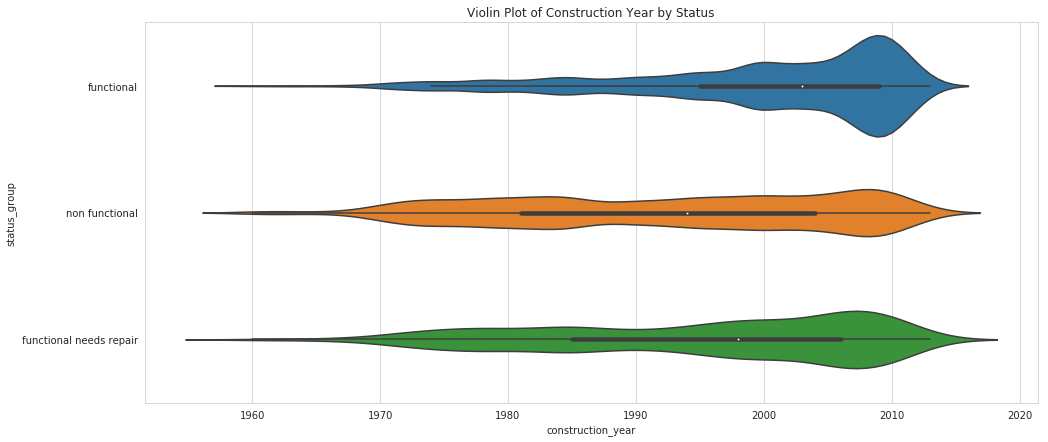

In [175]:
# boxplot construction year vs status
sns.set_style("whitegrid")

plt.figure(figsize = (16, 7))
sns.violinplot(data = full.loc[full['construction_year'] != 0], 
            x = "construction_year", y = "status_group")
plt.title("Violin Plot of Construction Year by Status")
plt.show()

##Based on the above plot, it appears that 'functional' wells are more likely to have been constructed more recently. This makse sense, older wells which have been in operation longer may be more likely to break down and need repairs or stop working altogether.

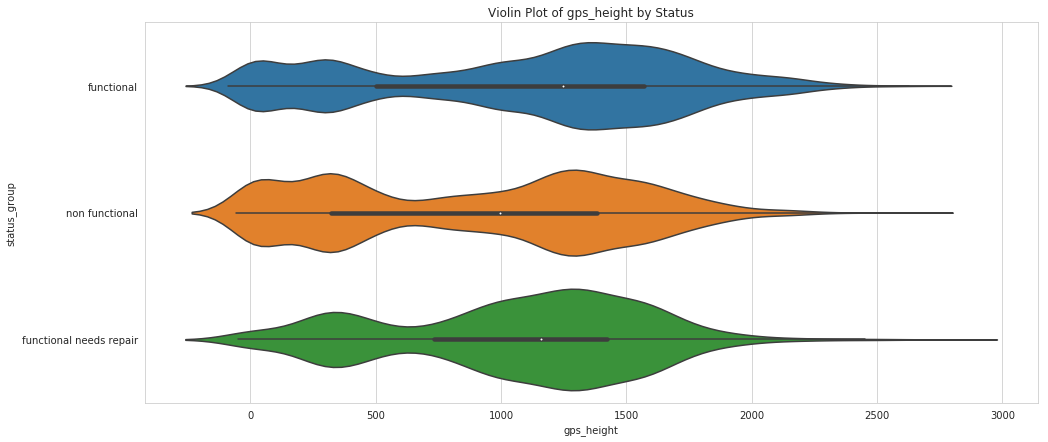

In [176]:
# plot gps_height
plt.figure(figsize = (16, 7))
sns.violinplot(data = full.loc[full["gps_height"] != 0], 
            x = "gps_height", y = "status_group")
plt.title("Violin Plot of gps_height by Status")
plt.show()

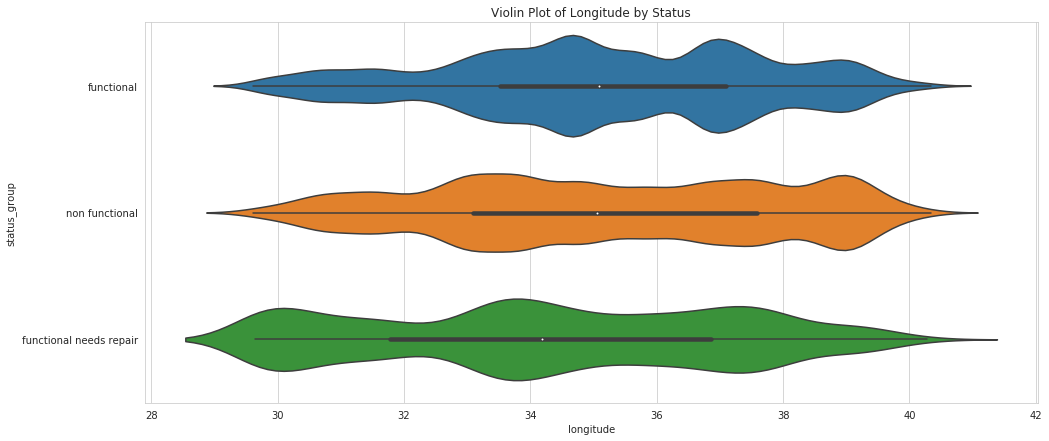

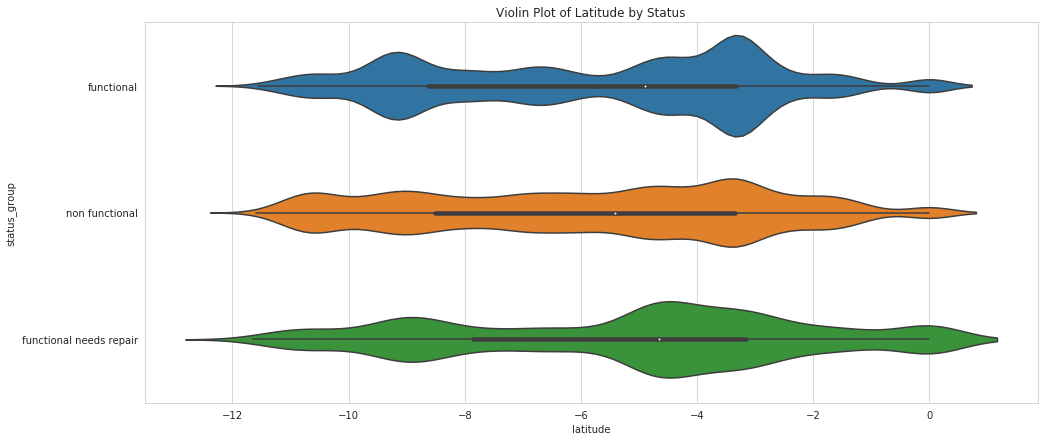

In [177]:
# plot longitude
plt.figure(figsize = (16, 7))
sns.violinplot(data = full.loc[full["longitude"] != 0], 
            x = "longitude", y = "status_group")
plt.title("Violin Plot of Longitude by Status")
plt.show()

# plot latitude
plt.figure(figsize = (16, 7))
sns.violinplot(data = full, 
            x = "latitude", y = "status_group")
plt.title("Violin Plot of Latitude by Status")
plt.show()

##The remaining figures are barplots of the various categorical variables broken down by 'status_group'. Several variables which have far too many factor levels are left out, as well as variables which contain redundant information. For example, 'payment' and 'payment_type' are two variables containing the exact same information.

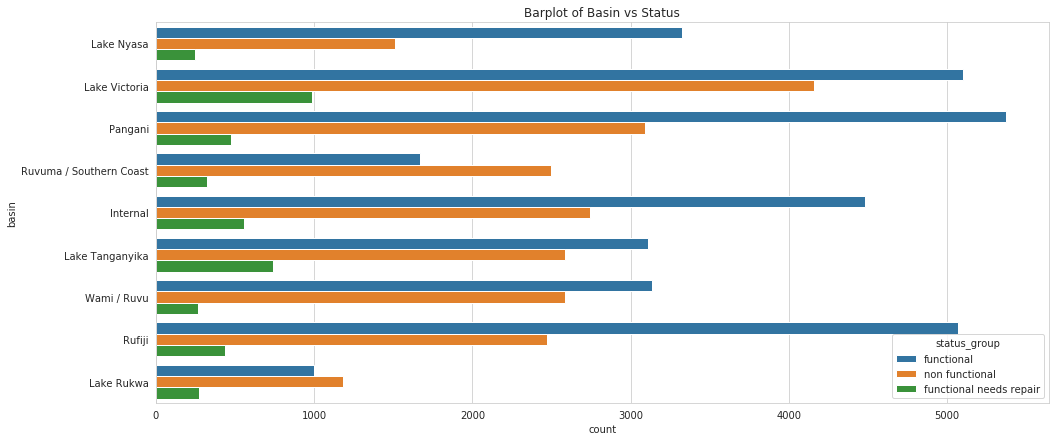

In [178]:
# bar plot of basin
plt.figure(figsize = (16,7))
sns.countplot(data = full, y = "basin", hue = "status_group", dodge = True)
plt.title("Barplot of Basin vs Status")
plt.show()

##It appears that several basins have a higher proportion of 'functional' wells (Lake Nyasa, Pangani, Internal, Rufiji), while some show the opposite. Ruvuma and Lake Rukwa have more wells which are 'non functional'.

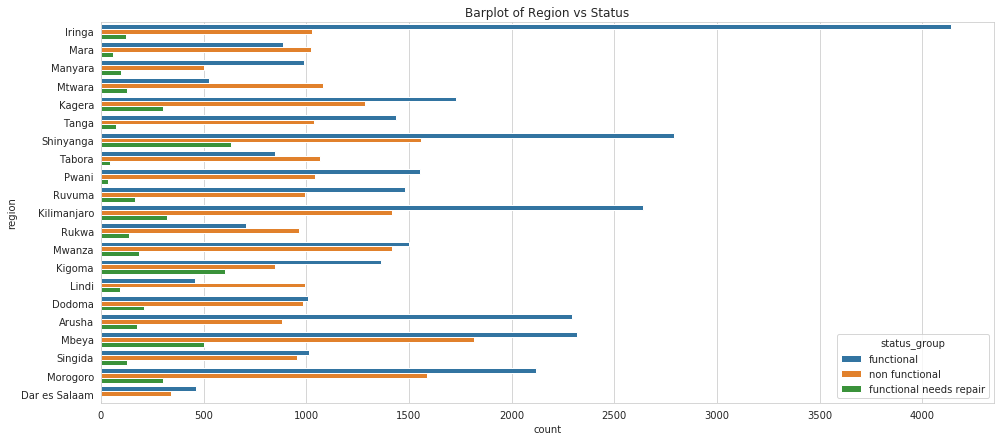

In [179]:
# bar plot of region
plt.figure(figsize = (16,7))
sns.countplot(data = full, y = "region", hue = "status_group", dodge = True)
plt.title("Barplot of Region vs Status")
plt.show()

##There are several regions where the wells are more likley to be 'functional' such as Iringa, Shinyanga, Kilimanjaro, Arusha, and several others. The regions Mtwara, Lindi, and a few others are more likely to have 'non functional' wells.

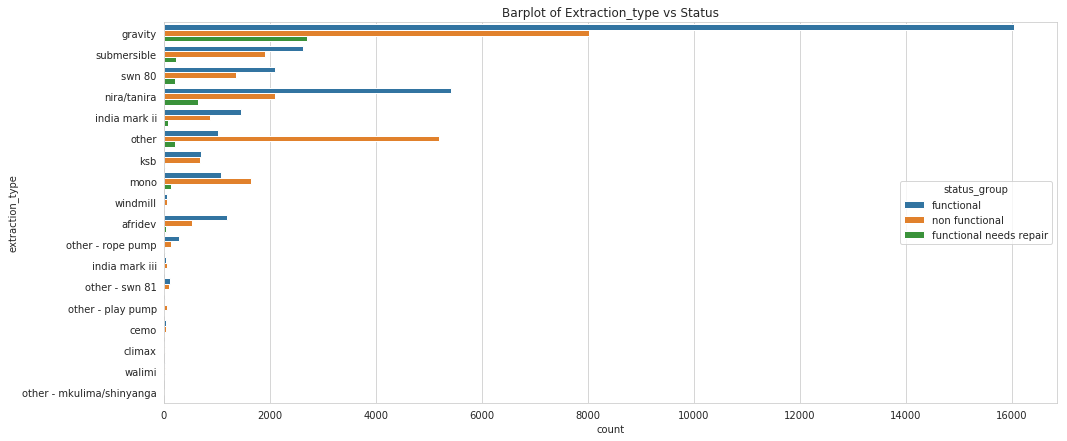

In [180]:
# bar plot of extraction_type
plt.figure(figsize = (16,7))
sns.countplot(data = full, y = "extraction_type", hue = "status_group", dodge = True)
plt.title("Barplot of Extraction_type vs Status")
plt.show()

##Wells of with extraction type 'other' and 'mono' are more likely to be non functional, while most other types are more likely to be functional.

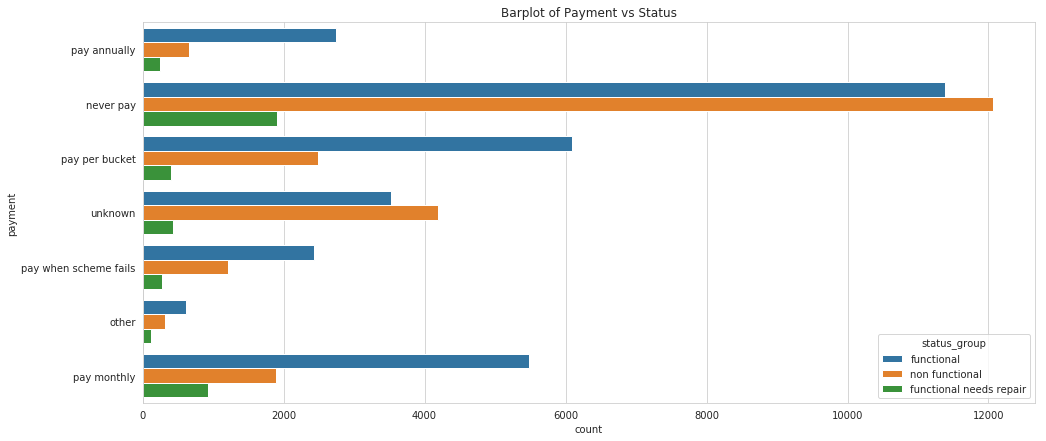

In [181]:
# bar plot of payment
plt.figure(figsize = (16,7))
sns.countplot(data = full, y = "payment", hue = "status_group", dodge = True)
plt.title("Barplot of Payment vs Status")
plt.show()

##Wells where people never pay, or where the payment type is unkown are more likely to be non functional.

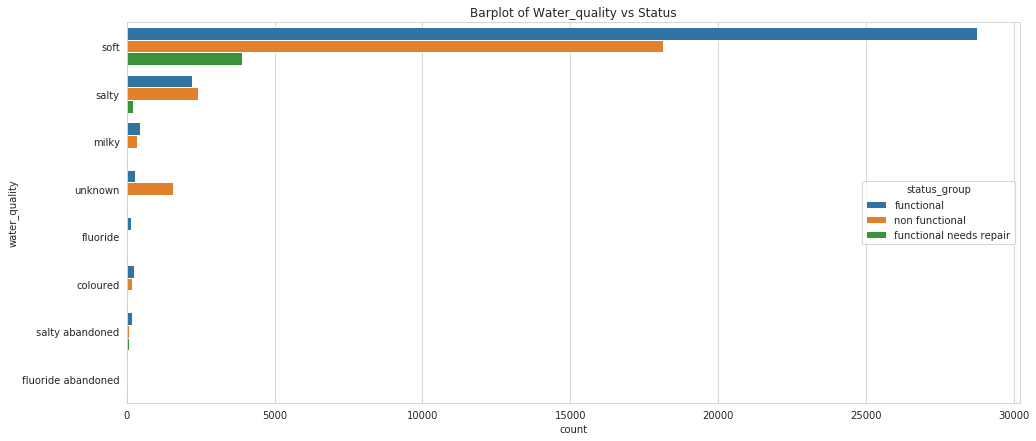

In [182]:
# bar plot of water quality
plt.figure(figsize = (16,7))
sns.countplot(data = full,
              y = "water_quality", hue = "status_group", dodge = True)
plt.title("Barplot of Water_quality vs Status")
plt.show()

##Wells with unknown or salty water type are more likely to be non functional, while most other types (especially soft water) are more likely to be functional.

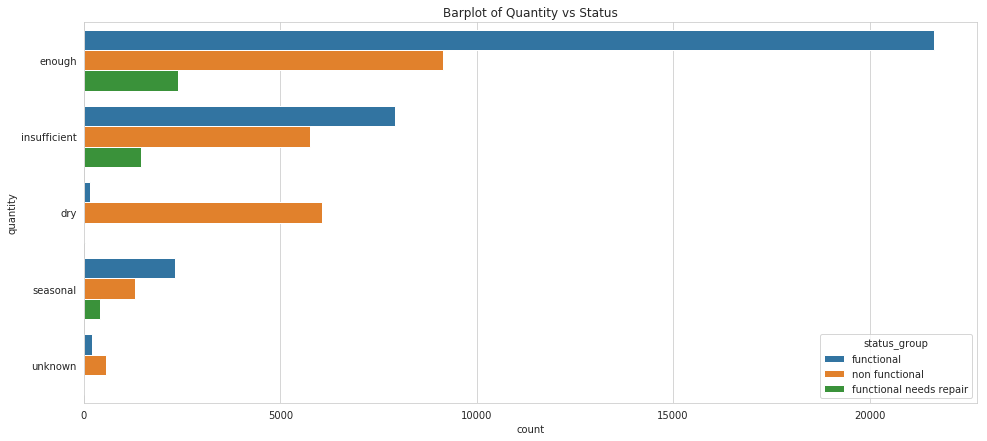

In [183]:
# bar plot of quantity
plt.figure(figsize = (16,7))
sns.countplot(data = full, y = "quantity", hue = "status_group", dodge = True)
plt.title("Barplot of Quantity vs Status")
plt.show()

##Wells where the water has dried up are *very* likely to be non functional, and if there's 'enough' water, the well is much more likely to be functional.

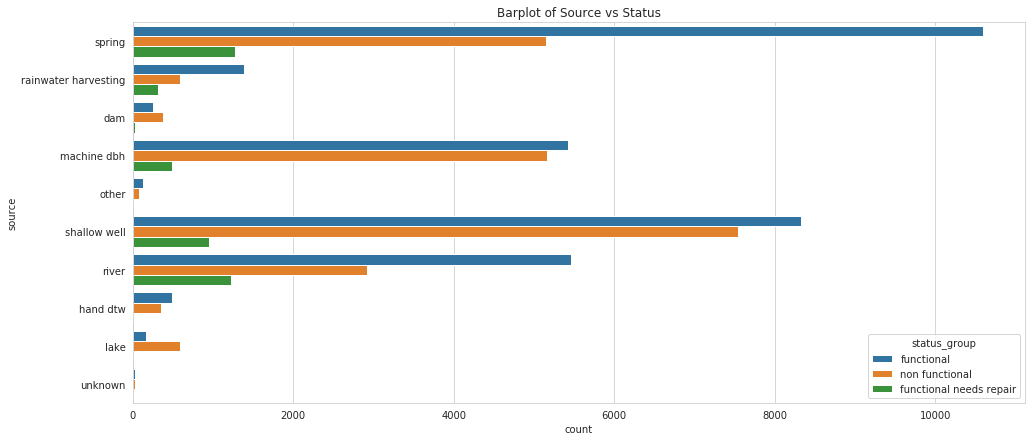

In [184]:
# bar plot of source
plt.figure(figsize = (16,7))
sns.countplot(data = full, y = "source", hue = "status_group", dodge = True)
plt.title("Barplot of Source vs Status")
plt.show()

##Spring, rainwater harvesting, and river sources are much more likely to have functional wells, while lake sourced wells are more likely to be non functional.

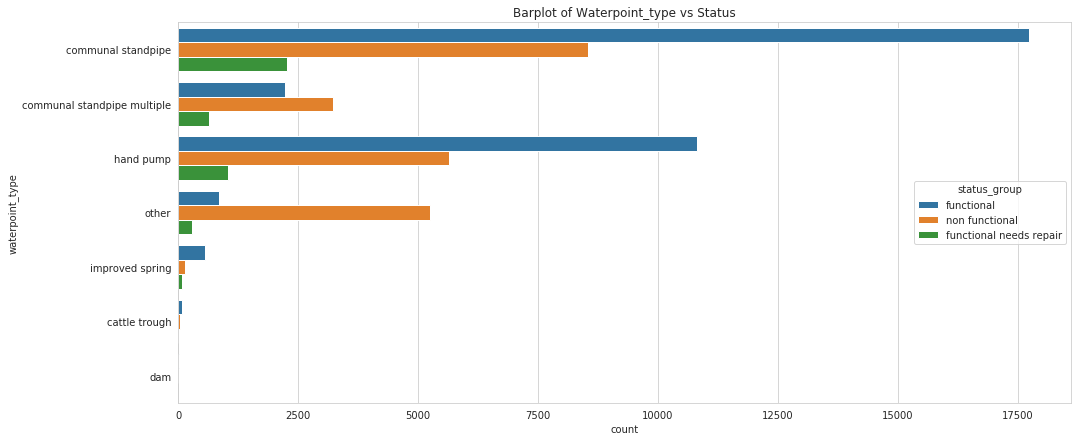

In [185]:
# bar plot of waterpoint_type
plt.figure(figsize = (16,7))
sns.countplot(data = full, y = "waterpoint_type", hue = "status_group", dodge = True)
plt.title("Barplot of Waterpoint_type vs Status")
plt.show()

##Waterpoint_type listed as 'other' is much more likely to be non functional, while communal standpipe and hand pumps are much more likely to be functional.



##Next we'll take a look at a map of Tanzania. Each point on the map represents a well, and the wells are color coded by status group. We want to see if there are any patterns in how the wells are distributed geographically. 

In [186]:
#install libraries
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install pyproj==1.9.6


Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.
     \ 163.5MB 2.4MB/s
  Created wheel for basemap: filename=basemap-1.2.0-cp36-cp36m-linux_x86_64.whl size=121756018 sha256=43629a522917cee9f5e22f4d5d089cf7fec1e86578e8824ba1930966d51ef136
  Stored in directory: /tmp/pip-ephem-wheel-cache-2dkpztiz/wheels/98/4a/fc/ce719b75d97e646645c225f3332b1b217536100314922e9572
Successfully built basemap


In [0]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
%matplotlib inline

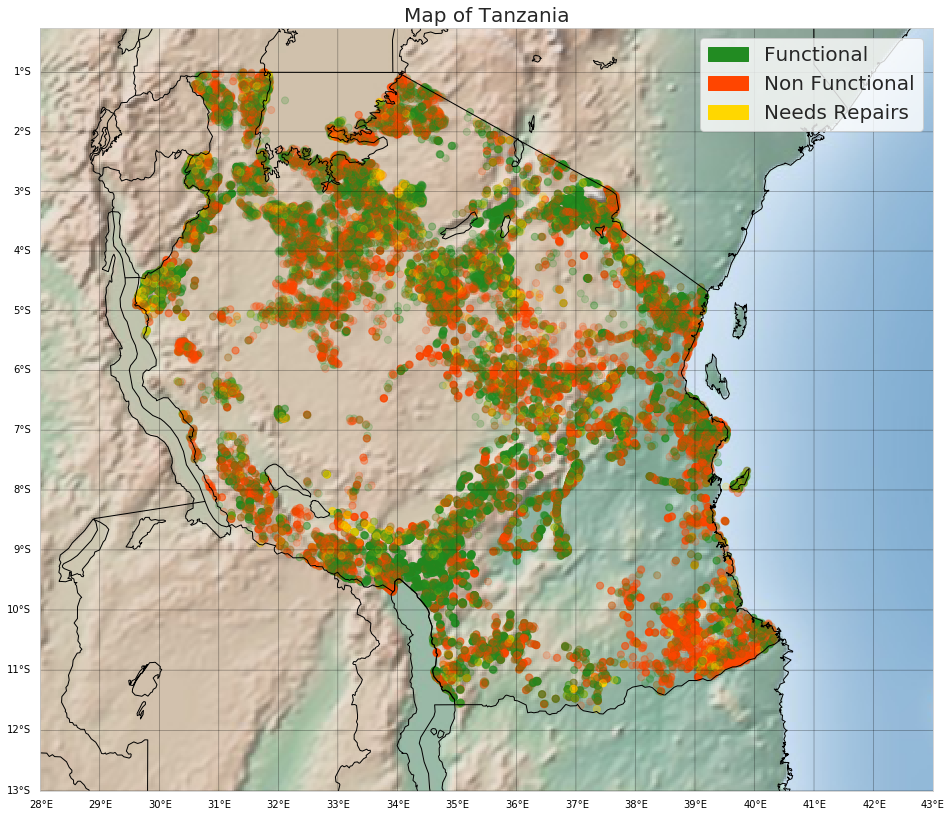

In [188]:
#Set up map of Tanzania
fig = plt.figure(figsize = (16, 16))
m = Basemap(projection = "mill",
           llcrnrlat = -13,
           urcrnrlat = -0.25,
           llcrnrlon = 28,
           urcrnrlon = 43,
           resolution = "i")
m.drawcoastlines()
m.drawcountries(linewidth = 1)
m.shadedrelief()

#draw latitude/longitude lines
m.drawparallels(np.arange(-90, 90, 1),
                labels = [True, False, False, False],
                linewidth = 0.5)
m.drawmeridians(np.arange(-180, 180, 1),
                labels=[0, 0, 0, 1],
                linewidth = 0.5)
plt.title("Map of Tanzania", fontsize = 20)

#get the lat/lon coordinates and color code
full["color"] = full["status_group"]
replacemap = {"color" : {"functional" : "forestgreen", 
                         "non functional" : "orangered", 
                         "functional needs repair" : "gold"}}
full.replace(replacemap, inplace = True)

lat_y = full["latitude"].tolist()
lon_x = full["longitude"].tolist()
colors = full["color"].tolist()

#add points on map
m.scatter(lon_x, lat_y, latlon = True, 
          s = 50, c = colors, alpha = 0.2)

#add legend
import matplotlib.patches as mpatches
f = mpatches.Patch(color = "forestgreen", label = "Functional")
nf = mpatches.Patch(color='orangered', label='Non Functional')
nr = mpatches.Patch(color = "gold", label = "Needs Repairs")
plt.legend(loc = "upper right",
           handles=[f, nf, nr],
           prop={'size': 20})

plt.show()

## It's difficult to see if there are any meaningful patterns in the map. There appear to be a few patches where there are more wells which are functional or non functional: for example at roughly 9 degrees S and 34.5 degrees E there are a lot of functional wells, and at about 10.5 degrees S and 39 degrees E there are many non-functional wells. It's possible that this information may be contained in the variables "region" or "basin", or others corresponding with geography.

##After taking a look at the data, we can start to get a better picture of what factors may help determine which wells are functional or not.  Newer constructed wells may be more likely to be functional, though it's unclear if other numerical features have much impact. Categorical features like the quantity and quality of water, the well's source, the type of payment used, and others including features corresponding to geographic location may help predict whether the well is functional.

# Statistical Inference

##Next we’ll run some hypothesis tests to see if we can find any helpful information about which features might be significant predictors of well functionality. Since we want to compare differences in means across different sized groups, we will use Welch’s two sample T-test. We’ll run the tests pair-wise to compare the ‘functional’, ‘non functional’, and ‘functional needs repair’ groups. We’ll set our alpha to equal 0.01.

In [189]:
# get columns of construction_year by status_group
yr_functional = full.construction_year[(full.status_group == "functional") & (full.construction_year != 0)]
yr_nonfunct = full.construction_year[(full.status_group == "non functional") & (full.construction_year != 0)]
yr_needrepair = full.construction_year[(full.status_group == "functional needs repair") & (full.construction_year != 0)]

# get mean of each group
mean_functional = np.mean(yr_functional)
mean_nonfunct = np.mean(yr_nonfunct)
mean_needrepair = np.mean(yr_needrepair)

# first test: functional vs non functional
stat, pvalue = stats.ttest_ind(yr_functional, 
                               yr_nonfunct, 
                               equal_var = False)
print("First test: functional vs non functional")
print("Mean construction year for functional wells: %.2f" % mean_functional)
print("Mean construction year for non-functional wells: %.2f" % mean_nonfunct)
print("P-value for Welch's T-test: %.10f" % pvalue)


# second test: functional vs needs repairs
stat, pvalue = stats.ttest_ind(yr_functional, 
                               yr_needrepair, 
                               equal_var = False)
print("\nSecond test: functional vs needing repairs")
print("Mean construction year for functional wells: %.2f" % mean_functional)
print("Mean construction year for wells needing repairs: %.2f" % mean_needrepair)
print("P-value for Welch's T-test: %.10f" % pvalue)

# third test: non functional vs needs repairs
stat, pvalue = stats.ttest_ind(yr_nonfunct, 
                               yr_needrepair, 
                               equal_var = False)
print("\nThird test: non functional vs needing repairs")
print("Mean construction year for non-functional wells: %.2f" % mean_nonfunct)
print("Mean construction year for wells needing repairs: %.2f" % mean_needrepair)
print("P-value for Welch's T-test: %.10f" % pvalue)

First test: functional vs non functional
Mean construction year for functional wells: 1999.94
Mean construction year for non-functional wells: 1992.40
P-value for Welch's T-test: 0.0000000000

Second test: functional vs needing repairs
Mean construction year for functional wells: 1999.94
Mean construction year for wells needing repairs: 1995.26
P-value for Welch's T-test: 0.0000000000

Third test: non functional vs needing repairs
Mean construction year for non-functional wells: 1992.40
Mean construction year for wells needing repairs: 1995.26
P-value for Welch's T-test: 0.0000000000


In [190]:
# get columns of gps_height by status_group
h_functional = full.gps_height[(full.status_group == "functional")]
h_nonfunct = full.gps_height[(full.status_group == "non functional")]
h_needrepair = full.gps_height[(full.status_group == "functional needs repair")]

# get mean of each group
mean_functional = np.mean(h_functional)
mean_nonfunct = np.mean(h_nonfunct)
mean_needrepair = np.mean(h_needrepair)

# first test: functional vs non functional
stat, pvalue = stats.ttest_ind(h_functional, 
                               h_nonfunct, 
                               equal_var = False)
print("First test: functional vs non functional")
print("Mean gps_height for functional wells: %.2f" % mean_functional)
print("Mean gps_height for non-functional wells: %.2f" % mean_nonfunct)
print("P-value for Welch's T-test: %.10f" % pvalue)


# second test: functional vs needs repairs
stat, pvalue = stats.ttest_ind(h_functional, 
                               h_needrepair, 
                               equal_var = False)
print("\nSecond test: functional vs needing repairs")
print("Mean gps_height for functional wells: %.2f" % mean_functional)
print("Mean gps_height for wells needing repairs: %.2f" % mean_needrepair)
print("P-value for Welch's T-test: %.10f" % pvalue)

# third test: non functional vs needs repairs
stat, pvalue = stats.ttest_ind(h_nonfunct, 
                               h_needrepair, 
                               equal_var = False)
print("\nThird test: non functional vs needing repairs")
print("Mean gps_height for non-functional wells: %.2f" % mean_nonfunct)
print("Mean gps_height for wells needing repairs: %.2f" % mean_needrepair)
print("P-value for Welch's T-test: %.10f" % pvalue)

First test: functional vs non functional
Mean gps_height for functional wells: 740.13
Mean gps_height for non-functional wells: 574.46
P-value for Welch's T-test: 0.0000000000

Second test: functional vs needing repairs
Mean gps_height for functional wells: 740.13
Mean gps_height for wells needing repairs: 627.61
P-value for Welch's T-test: 0.0000000000

Third test: non functional vs needing repairs
Mean gps_height for non-functional wells: 574.46
Mean gps_height for wells needing repairs: 627.61
P-value for Welch's T-test: 0.0000007818


In [191]:
# get columns of longitude by status_group
functional = full.longitude[(full.status_group == "functional") & (full.longitude != 0)]
nonfunct = full.longitude[(full.status_group == "non functional") & (full.longitude != 0)]
needrepair = full.longitude[(full.status_group == "functional needs repair") & (full.longitude != 0)]

# get mean of each group
mean_functional = np.mean(functional)
mean_nonfunct = np.mean(nonfunct)
mean_needrepair = np.mean(needrepair)

# first test: functional vs non functional
stat, pvalue = stats.ttest_ind(functional, 
                               nonfunct, 
                               equal_var = False)
print("First test: functional vs non functional")
print("Mean longitude for functional wells: %.6f" % mean_functional)
print("Mean longitude for non-functional wells: %.6f" % mean_nonfunct)
print("P-value for Welch's T-test: %.10f" % pvalue)


# second test: functional vs needs repairs
stat, pvalue = stats.ttest_ind(functional, 
                               needrepair, 
                               equal_var = False)
print("\nSecond test: functional vs needing repairs")
print("Mean longitude for functional wells: %.6f" % mean_functional)
print("Mean longitude for wells needing repairs: %.6f" % mean_needrepair)
print("P-value for Welch's T-test: %.10f" % pvalue)

# third test: non functional vs needs repairs
stat, pvalue = stats.ttest_ind(nonfunct, 
                               needrepair, 
                               equal_var = False)
print("\nThird test: non functional vs needing repairs")
print("Mean longitude for non-functional wells: %.6f" % mean_nonfunct)
print("Mean longitude for wells needing repairs: %.6f" % mean_needrepair)
print("P-value for Welch's T-test: %.10f" % pvalue)

First test: functional vs non functional
Mean longitude for functional wells: 35.191149
Mean longitude for non-functional wells: 35.239450
P-value for Welch's T-test: 0.0351669196

Second test: functional vs needing repairs
Mean longitude for functional wells: 35.191149
Mean longitude for wells needing repairs: 34.309867
P-value for Welch's T-test: 0.0000000000

Third test: non functional vs needing repairs
Mean longitude for non-functional wells: 35.239450
Mean longitude for wells needing repairs: 34.309867
P-value for Welch's T-test: 0.0000000000


In [192]:
# get columns of latitude by status_group
functional = full.latitude[(full.status_group == "functional") & (full.latitude != 0)]
nonfunct = full.latitude[(full.status_group == "non functional") & (full.latitude != 0)]
needrepair = full.latitude[(full.status_group == "functional needs repair") & (full.latitude != 0)]

# get mean of each group
mean_functional = np.mean(functional)
mean_nonfunct = np.mean(nonfunct)
mean_needrepair = np.mean(needrepair)

# first test: functional vs non functional
stat, pvalue = stats.ttest_ind(functional, 
                               nonfunct, 
                               equal_var = False)
print("First test: functional vs non functional")
print("Mean latitude for functional wells: %.6f" % mean_functional)
print("Mean latitude for non-functional wells: %.6f" % mean_nonfunct)
print("P-value for Welch's T-test: %.10f" % pvalue)


# second test: functional vs needs repairs
stat, pvalue = stats.ttest_ind(functional, 
                               needrepair, 
                               equal_var = False)
print("\nSecond test: functional vs needing repairs")
print("Mean latitude for functional wells: %.6f" % mean_functional)
print("Mean latitude for wells needing repairs: %.6f" % mean_needrepair)
print("P-value for Welch's T-test: %.10f" % pvalue)

# third test: non functional vs needs repairs
stat, pvalue = stats.ttest_ind(nonfunct, 
                               needrepair, 
                               equal_var = False)
print("\nThird test: non functional vs needing repairs")
print("Mean latitude for non-functional wells: %.6f" % mean_nonfunct)
print("Mean latitude for wells needing repairs: %.6f" % mean_needrepair)
print("P-value for Welch's T-test: %.10f" % pvalue)

First test: functional vs non functional
Mean latitude for functional wells: -5.704921
Mean latitude for non-functional wells: -5.810394
P-value for Welch's T-test: 0.0000340675

Second test: functional vs needing repairs
Mean latitude for functional wells: -5.704921
Mean latitude for wells needing repairs: -5.162580
P-value for Welch's T-test: 0.0000000000

Third test: non functional vs needing repairs
Mean latitude for non-functional wells: -5.810394
Mean latitude for wells needing repairs: -5.162580
P-value for Welch's T-test: 0.0000000000


##After running many hypothesis tests, we’ve found almost every p-value to be significant. The only one that wasn’t was the average longitude for functional vs non functional wells. Part of this is due to the fact that we have so many data observations. It might be a good indicator that longitude is not a significant factor in determining if a well is functional or not functional, since despite the large amount of data, we did not get significance.

# Feature Engineering
##Next we’ll want to do some feature engineering, to see if we can extract some useful information out of  the variables. We’re going to create a new variable called ‘age’ which will represent the age of each well (in years) at the time the data observation was recorded. We will compute this by finding the difference between ‘construction_year’ and ‘date_recorded’.

In [0]:
# replace zeros in ocnstruction year with median
yrmedian = np.median(full["construction_year"])

replacemap = {"construction_year" : {0 : yrmedian}}
full.replace(replacemap, inplace = True)

In [0]:
# convert columns to datetime format
full["date_recorded"] = pd.to_datetime(full["date_recorded"])

full["temp"] = pd.to_datetime(full["construction_year"], format='%Y')

In [195]:
# get difference between construction year and year of recording
full["age"] = full["date_recorded"] - full["temp"]

#convert timedelta to years
full["age"] = full["age"] / np.timedelta64(1, 'Y')

full.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,color,temp,age
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999.0,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,forestgreen,1999-01-01,12.197376
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010.0,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,forestgreen,2010-01-01,3.175972
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009.0,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,forestgreen,2009-01-01,4.150667
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986.0,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,orangered,1986-01-01,27.075162
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,1986.0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,forestgreen,1986-01-01,25.528245


##Before we make these changes final, lets do the same exploratory analysis as before. We’ll look at a plot of the age grouped by the three statuses, and then do a hypothesis test as before.

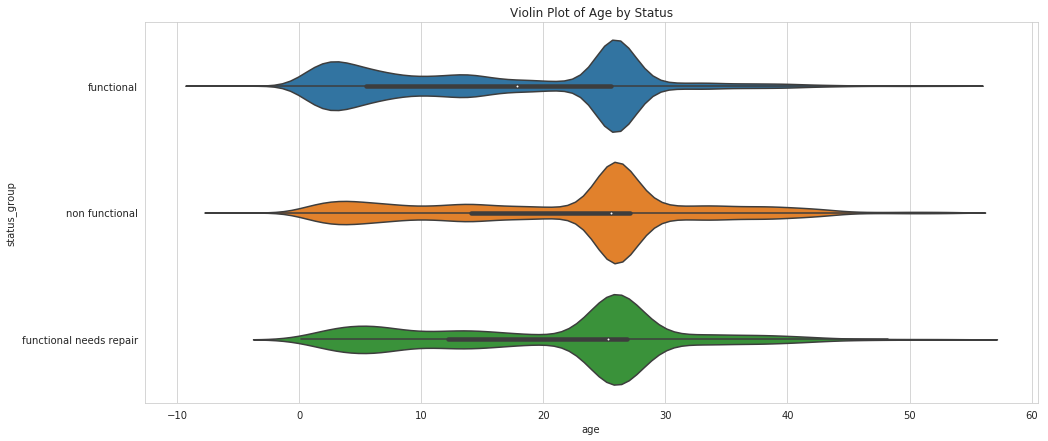

In [196]:
plt.figure(figsize = (16, 7))
sns.violinplot(data = full, 
               x = "age", y = "status_group")
plt.title("Violin Plot of Age by Status")
plt.show()

In [197]:
# get columns of age by status_group
functional = full.age[(full.status_group == "functional")]
nonfunct = full.age[(full.status_group == "non functional")]
needrepair = full.age[(full.status_group == "functional needs repair")]

# get mean of each group
mean_functional = np.mean(functional)
mean_nonfunct = np.mean(nonfunct)
mean_needrepair = np.mean(needrepair)

# first test: functional vs non functional
stat, pvalue = stats.ttest_ind(functional, 
                               nonfunct, 
                               equal_var = False)
print("First test: functional vs non functional")
print("Mean age for functional wells: %.6f" % mean_functional)
print("Mean age for non-functional wells: %.6f" % mean_nonfunct)
print("P-value for Welch's T-test: %.10f" % pvalue)


# second test: functional vs needs repairs
stat, pvalue = stats.ttest_ind(functional, 
                               needrepair, 
                               equal_var = False)
print("\nSecond test: functional vs needing repairs")
print("Mean age for functional wells: %.6f" % mean_functional)
print("Mean age for wells needing repairs: %.6f" % mean_needrepair)
print("P-value for Welch's T-test: %.10f" % pvalue)

# third test: non functional vs needs repairs
stat, pvalue = stats.ttest_ind(nonfunct, 
                               needrepair, 
                               equal_var = False)
print("\nThird test: non functional vs needing repairs")
print("Mean age for non-functional wells: %.6f" % mean_nonfunct)
print("Mean age for wells needing repairs: %.6f" % mean_needrepair)
print("P-value for Welch's T-test: %.10f" % pvalue)

First test: functional vs non functional
Mean age for functional wells: 16.831565
Mean age for non-functional wells: 22.209291
P-value for Welch's T-test: 0.0000000000

Second test: functional vs needing repairs
Mean age for functional wells: 16.831565
Mean age for wells needing repairs: 20.946728
P-value for Welch's T-test: 0.0000000000

Third test: non functional vs needing repairs
Mean age for non-functional wells: 22.209291
Mean age for wells needing repairs: 20.946728
P-value for Welch's T-test: 0.0000000000


##It seems that based on the plot, the functional wells are more likely to have a lower age than the other groups, and once again all hypothesis tests showed significance. We’ll see later if this new feature helps our model out or not.

# Impute Missing Data
##Now it’s time to impute the missing data, since as we saw before, we have many zero entries to deal with. We’ll use the median value of each numeric variable to replace the missing data. Next we’ll just double check that there are no more zero entries in the data.

In [0]:
# replace zeros in train set with median
gpsmedian = np.median(full["gps_height"])
lonmedian = np.median(full["longitude"])
popmedian = np.median(full["population"])
yrmedian = np.median(full["construction_year"])

replacemap = {"gps_height" : {0 : gpsmedian},
              "longitude" : {0 : lonmedian},
              "population" : {0 : popmedian},
              "construction_year" : {0 : yrmedian}}

full.replace(replacemap, inplace = True)

# replace zeros in test set with median
gpsmedian = np.median(test["gps_height"])
lonmedian = np.median(test["longitude"])
popmedian = np.median(test["population"])
yrmedian = np.median(test["construction_year"])

replacemap = {"gps_height" : {0 : gpsmedian},
              "longitude" : {0 : lonmedian},
              "population" : {0 : popmedian},
              "construction_year" : {0 : yrmedian}}

test.replace(replacemap, inplace = True)

In [0]:
# repeat for the test set
# convert date_recorded & construction_year to datetime format
test["date_recorded"] = pd.to_datetime(test["date_recorded"])

test["temp"] = pd.to_datetime(test["construction_year"], format='%Y')

# get difference between construction year and year of recording
test["age"] = test["date_recorded"] - test["temp"]

#convert frequency to years
test["age"] = test["age"] / np.timedelta64(1, 'Y')

In [200]:
# take a look at how many zeros are in the data
print("gps_height entries equal to zero: ", np.sum(full.gps_height == 0))
print("longitude entries equal to zero: ", np.sum(full.longitude == 0))
print("population entries equal to zero: ", np.sum(full.population == 0))
print("construction_year entries equal to zero: ", np.sum(full.construction_year == 0))

gps_height entries equal to zero:  0
longitude entries equal to zero:  0
population entries equal to zero:  0
construction_year entries equal to zero:  0


##Here we remove columns that will not be in our model. Many columns contain redundant information, and two variables in particular (amount_tsh and num_private) have almost all zero entries.

In [0]:
# remove columns that have redundant information or too much missing data
cols = ["id", "amount_tsh", "date_recorded", "wpt_name", "num_private", 
        "subvillage", "region_code", "ward", "public_meeting", "recorded_by", 
        "scheme_management", "scheme_name", "permit", "extraction_type_group", 
        "extraction_type_class", "management_group", "payment", "quality_group", 
        "quantity_group", "source_type", "source_class", "waterpoint_type_group",
        "temp"]

#train = train.drop(columns = cols)
testid = test["id"]
test = test.drop(columns = cols)

full = full.drop(columns = ["color"])
full = full.drop(columns = cols)

In [202]:
full.head()

,funder,gps_height,installer,longitude,latitude,basin,region,district_code,lga,population,construction_year,extraction_type,management,payment_type,water_quality,quantity,source,waterpoint_type,status_group,age
0,Roman,1390.0,Roman,34.938093,-9.856322,Lake Nyasa,Iringa,5,Ludewa,109.0,1999.0,gravity,vwc,annually,soft,enough,spring,communal standpipe,functional,12.197376
1,Grumeti,1399.0,GRUMETI,34.698766,-2.147466,Lake Victoria,Mara,2,Serengeti,280.0,2010.0,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,functional,3.175972
2,Lottery Club,686.0,World vision,37.460664,-3.821329,Pangani,Manyara,4,Simanjiro,250.0,2009.0,gravity,vwc,per bucket,soft,enough,dam,communal standpipe multiple,functional,4.150667
3,Unicef,263.0,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,63,Nanyumbu,58.0,1986.0,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple,non functional,27.075162
4,Action In A,369.0,Artisan,31.130847,-1.825359,Lake Victoria,Kagera,1,Karagwe,25.0,1986.0,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,functional,25.528245


In [203]:
test.head()

,funder,gps_height,installer,longitude,latitude,basin,region,district_code,lga,population,construction_year,extraction_type,management,payment_type,water_quality,quantity,source,waterpoint_type,age
0,Dmdd,1996.0,DMDD,35.290799,-4.059696,Internal,Manyara,3,Mbulu,321.0,2012.0,other,parastatal,never pay,soft,seasonal,rainwater harvesting,other,1.095163
1,Government Of Tanzania,1569.0,DWE,36.656709,-3.309214,Pangani,Arusha,2,Arusha Rural,300.0,2000.0,gravity,vwc,never pay,soft,insufficient,spring,communal standpipe,13.095409
2,NaN,1567.0,NaN,34.767863,-5.004344,Internal,Singida,2,Singida Rural,500.0,2010.0,other,vwc,never pay,soft,insufficient,rainwater harvesting,other,3.085621
3,Finn Water,267.0,FINN WATER,38.058046,-9.418672,Ruvuma / Southern Coast,Lindi,43,Liwale,250.0,1987.0,other,vwc,unknown,soft,dry,shallow well,other,26.059399
4,Bruder,1260.0,BRUDER,35.006123,-10.950412,Ruvuma / Southern Coast,Ruvuma,3,Mbinga,60.0,2000.0,gravity,water board,monthly,soft,enough,spring,communal standpipe,13.235042


##Next we’ll need to turn the string variables into categorical variables encoded numerically, so that the dataframe will work with SciKitLearn. We do this using pd.factorize().

In [0]:
# change to categorical variables
full["funder"] = pd.factorize(full["funder"])[0]
full["installer"] = pd.factorize(full["installer"])[0]
full["basin"] = pd.factorize(full["basin"])[0]
full["region"] = pd.factorize(full["region"])[0]
full["lga"] = pd.factorize(full["lga"])[0]
full["extraction_type"] = pd.factorize(full["extraction_type"])[0]
full["management"] = pd.factorize(full["management"])[0]
full["payment_type"] = pd.factorize(full["payment_type"])[0]
full["water_quality"] = pd.factorize(full["water_quality"])[0]
full["quantity"] = pd.factorize(full["quantity"])[0]
full["source"] = pd.factorize(full["source"])[0]
full["waterpoint_type"] = pd.factorize(full["waterpoint_type"])[0]

# test set
test["funder"] = pd.factorize(test["funder"])[0]
test["installer"] = pd.factorize(test["installer"])[0]
test["basin"] = pd.factorize(test["basin"])[0]
test["region"] = pd.factorize(test["region"])[0]
test["lga"] = pd.factorize(test["lga"])[0]
test["extraction_type"] = pd.factorize(test["extraction_type"])[0]
test["management"] = pd.factorize(test["management"])[0]
test["payment_type"] = pd.factorize(test["payment_type"])[0]
test["water_quality"] = pd.factorize(test["water_quality"])[0]
test["quantity"] = pd.factorize(test["quantity"])[0]
test["source"] = pd.factorize(test["source"])[0]
test["waterpoint_type"] = pd.factorize(test["waterpoint_type"])[0]

In [205]:
# change labels to numerical values
replacemap = {"status_group" : {'functional' : 0 , 
                                'non functional' : 1, 
                                'functional needs repair' : 2}}
full.replace(replacemap, inplace = True)
full.head()


,funder,gps_height,installer,longitude,latitude,basin,region,district_code,lga,population,construction_year,extraction_type,management,payment_type,water_quality,quantity,source,waterpoint_type,status_group,age
0,0,1390.0,0,34.938093,-9.856322,0,0,5,0,109.0,1999.0,0,0,0,0,0,0,0,0,12.197376
1,1,1399.0,1,34.698766,-2.147466,1,1,2,1,280.0,2010.0,0,1,1,0,1,1,0,0,3.175972
2,2,686.0,2,37.460664,-3.821329,2,2,4,2,250.0,2009.0,0,0,2,0,0,2,1,0,4.150667
3,3,263.0,3,38.486161,-11.155298,3,3,63,3,58.0,1986.0,1,0,1,0,2,3,1,1,27.075162
4,4,369.0,4,31.130847,-1.825359,1,4,1,4,25.0,1986.0,0,2,1,0,3,1,0,0,25.528245


# Machine Learning
##Now it’s finally time to start building our model. We’ll start by splitting our data into train and validation sets, so we can check the accuracy. Then we’ll want to start with a very simple model to use as a baseline. From this, we’ll check the accuracy and use it to compare. Hopefully, more complicated models will produce more accurate results (if not, we’ll know something didn’t go right). We’ll be using a decision tree for this benchmark.

In [0]:
# set seed and split into train/validation sets
full_labels = pd.DataFrame(full["status_group"])
full = full.drop(columns = ["status_group"])
np.random.seed(12345)
X_train, X_test, Y_train, Y_test = train_test_split(full, full_labels, 
                                                    test_size = 0.25)


In [207]:
# Decision Tree
dt = DecisionTreeClassifier()
# fit model
dt.fit(X_train,Y_train["status_group"])
# make prediction
dt_pred = dt.predict(X_test)
# check accuracy
dt_acc = metrics.accuracy_score(Y_test["status_group"], dt_pred)
print("Decision Tree benchmark accuracy: {}".format(dt_acc))

Decision Tree benchmark accuracy: 0.7571717171717172


In [208]:
# build random forest model
# create Classifier
rf = RandomForestClassifier(n_estimators = 250)

# train the model 
rf.fit(X_train, Y_train["status_group"])

# make prediction on validation set
pred = rf.predict(X_test)

# check accuracy
acc = metrics.accuracy_score(Y_test["status_group"], pred)
print("First Random Forest model accuracy: {}".format(acc))

First Random Forest model accuracy: 0.8061952861952862


##Our benchmark to beat is about 0.757. Our first attempt at building a random forest model gave an accuracy of about 0.806, not bad.
# Feature Importance
##One problem we might have is overfitting. To combat this, we are first going to look at feature importance, to determine which variables are actually important for our model. We’ll start out using SciKitLearn’s built in methods for analyzing feature importance.

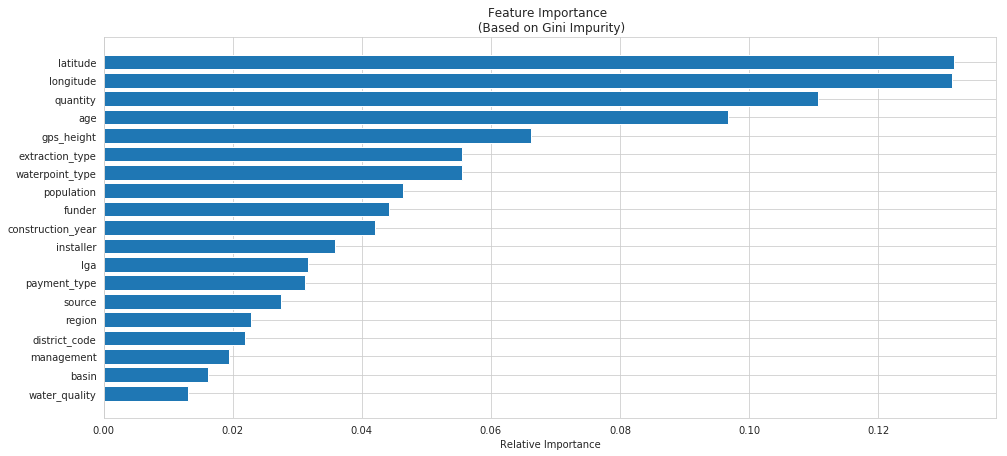

In [209]:
# Check feature importance using Gini Impurity method
feature_importance = pd.DataFrame(rf.feature_importances_,
                                  index = X_train.columns,
                                  columns = ['importance']).sort_values('importance')
# plot bargraph of feature importances
plt.figure(figsize = (16, 7))
plt.barh(y = feature_importance.index, width = feature_importance["importance"])
plt.title("Feature Importance \n (Based on Gini Impurity)")
plt.xlabel("Relative Importance")
plt.show()

##Interesting that this seems to indicate longitude and latitude are the two most important features, even though we saw earlier that when we did a hypothesis comparing mean longitude, we did not get a significant p-value when comparing functional and non functional wells. So what happened? Apparently, this method can over emphasize the importance of continuous variables, as well as categorical variables with a high number of levels. So, to double check we’ll use a second method for analyzing feature importance. We will do this by dropping each column one at a time, and comparing the difference in performance to the full model. This is computationally more costly, but should yield better results.

In [0]:
# set benchmark score (before dropping any features)
benchmark = rf.score(X_train, Y_train["status_group"])

#initialize empty list of importances
importance = []

# loop over all columns in the training set
for col in X_train.columns:
    # create a copy of the model
    model_clone = clone(rf)
    model_clone.random_state = 12345
    # fit new model with dropped column
    model_clone.fit(X_train.drop(col, axis = 1), 
                    Y_train["status_group"])
    # calculate new score
    drop_score = model_clone.score(X_train.drop(col, axis = 1), 
                                   Y_train["status_group"])
    # compare difference between new score and benchamrk
    importance.append(benchmark - drop_score)

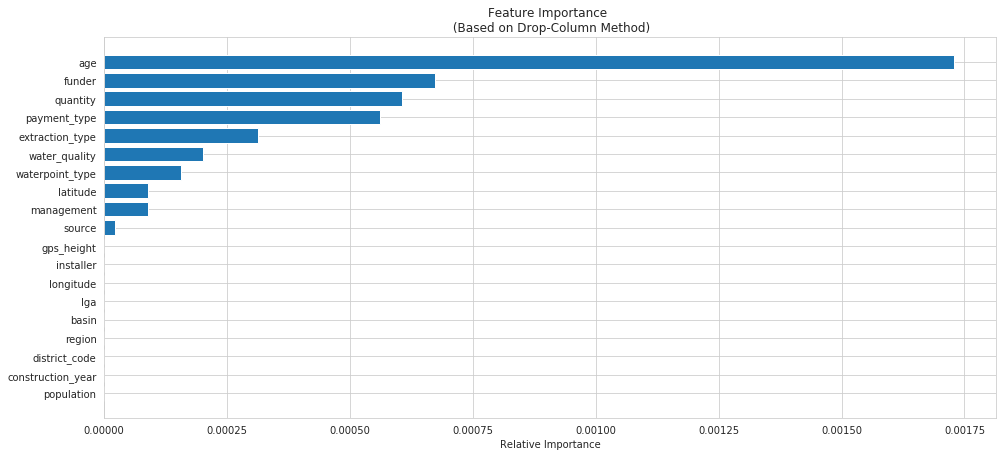

In [101]:
# create data frame of feature importances and sort it
drop_imp = pd.DataFrame({'feature': X_train.columns, 
                         'feature_importance': importance}).sort_values('feature_importance')
# plot feature importances
plt.figure(figsize = (16, 7))
plt.barh(y = drop_imp.feature, width = drop_imp.feature_importance)
plt.title("Feature Importance \n (Based on Drop-Column Method)")
plt.xlabel("Relative Importance")
plt.show()

##So it seems we have completely different results. Longitude is no longer appearing to have any importance at all, along with several other variables. Also interesting, the age variable we created earlier, now appears to be the most important feature. So it’s a good thing we took the time to do some extra feature engineering. 

##With that in mind, we'll attempt to do some extra feature engineering, and see if we can take the latitude and longitude data and transform it into a feature that might be useful. We'll try using KMeans clustering to transform the data. We'll need to test out different values for k (the number of clusters) and compare the sum of squares using an "elbow" plot. Where the bend appears in the plot will indicate which value we might want to choose for k.




In [210]:
# get a dataframe of the longitude & latitude
df = full.loc[:, ["longitude", "latitude"]]
dftest = test.loc[:, ["longitude", "latitude"]]
df.head()

,longitude,latitude
0,34.938093,-9.856322
1,34.698766,-2.147466
2,37.460664,-3.821329
3,38.486161,-11.155298
4,31.130847,-1.825359


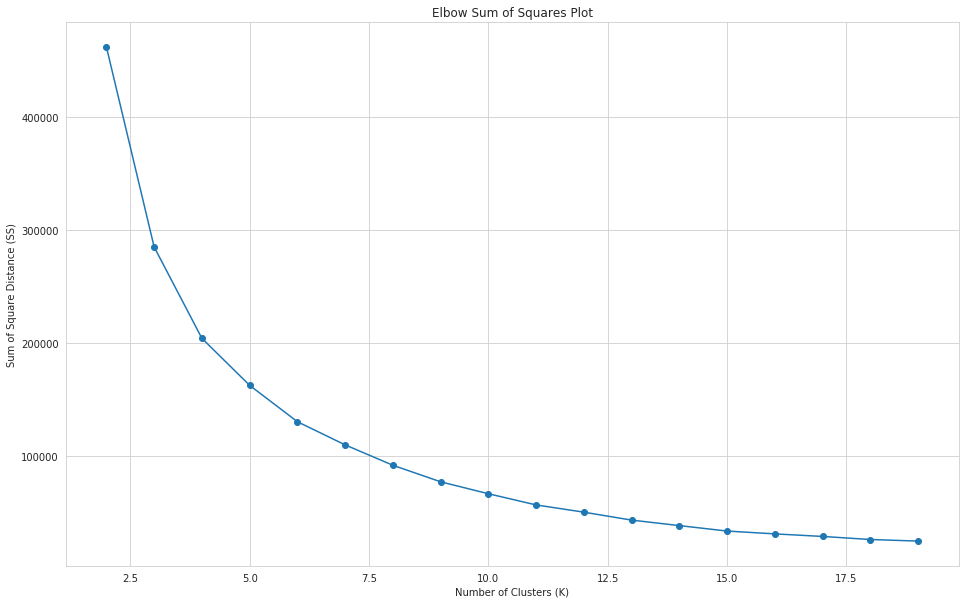

In [211]:
# initialize possible values for k, and empty vector for sum of squares values
k_vals = np.arange(2, 20)
SS = []

np.random.seed(12345)
# create KMeans for each k, store SS
for k in k_vals:
    kmModel = KMeans(n_clusters = k)
    kmModel.fit(df)
    SS.append(kmModel.inertia_)
    
#plot 
plt.figure(figsize=(16, 10))
plt.plot(k_vals, SS, marker = "o")
plt.ylabel("Sum of Square Distance (SS)")
plt.xlabel("Number of Clusters (K)")
plt.title("Elbow Sum of Squares Plot")
plt.show()

##At around k = 4, there is a bend in the curve, so we'll choose k  = 4 for our clustering algorithm.

In [212]:
# make best model (choose k = 4)
best = KMeans(n_clusters = 4)
best.fit(df)
# get the clusters
clusters = best.predict(df)
full["clusters"] = clusters
# drop long/lat columns
full2 = full.drop(columns = ["longitude", "latitude"])

# do the same for the test set
best = KMeans(n_clusters = 4)
best.fit(dftest)
clusters = best.predict(dftest)
test["clusters"] = clusters
test2 = test.drop(columns = ["longitude", "latitude"])

full2.head()

,funder,gps_height,installer,basin,region,district_code,lga,population,construction_year,extraction_type,management,payment_type,water_quality,quantity,source,waterpoint_type,age,clusters
0,0,1390.0,0,0,0,5,0,109.0,1999.0,0,0,0,0,0,0,0,12.197376,1
1,1,1399.0,1,1,1,2,1,280.0,2010.0,0,1,1,0,1,1,0,3.175972,0
2,2,686.0,2,2,2,4,2,250.0,2009.0,0,0,2,0,0,2,1,4.150667,3
3,3,263.0,3,3,3,63,3,58.0,1986.0,1,0,1,0,2,3,1,27.075162,2
4,4,369.0,4,1,4,1,4,25.0,1986.0,0,2,1,0,3,1,0,25.528245,0


In [216]:
np.random.seed(12345)
X_train, X_test, Y_train, Y_test = train_test_split(full2, full_labels, 
                                                    test_size = 0.25)

# columns to be dropped
col = ["gps_height", "installer", "lga", "basin", "region", "district_code", 
       "construction_year", "population"]

X_train = X_train.drop(columns = col)
X_test = X_test.drop(columns = col)

X_train.head()

,funder,extraction_type,management,payment_type,water_quality,quantity,source,waterpoint_type,age,clusters
33576,87,2,0,1,0,0,5,2,5.196547,2
25269,69,1,6,1,0,0,3,0,3.217041,2
1504,309,5,0,1,0,0,5,2,17.131084,2
16093,8,9,0,4,0,0,3,2,27.042308,0
2467,44,6,0,1,0,0,2,0,26.782206,0


In [218]:
# build random forest model
# create Classifier
rf = RandomForestClassifier(n_estimators = 250)

# train the model 
rf.fit(X_train, Y_train["status_group"])

# make prediction on validation set
pred = rf.predict(X_test)

# check accuracy
acc = metrics.accuracy_score(Y_test["status_group"], pred)
print("First Random Forest model accuracy: {}".format(acc))

First Random Forest model accuracy: 0.7891582491582492


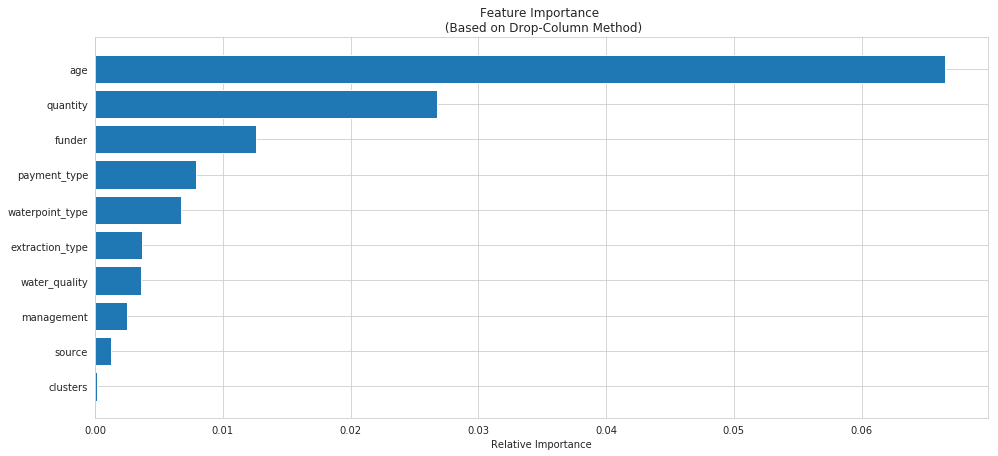

In [219]:
# set benchmark score (before dropping any features)
benchmark = rf.score(X_train, Y_train["status_group"])

#initialize empty list of importances
importance = []

# loop over all columns in the training set
for col in X_train.columns:
    # create a copy of the model
    model_clone = clone(rf)
    model_clone.random_state = 12345
    # fit new model with dropped column
    model_clone.fit(X_train.drop(col, axis = 1), 
                    Y_train["status_group"])
    # calculate new score
    drop_score = model_clone.score(X_train.drop(col, axis = 1), 
                                   Y_train["status_group"])
    # compare difference between new score and benchamrk
    importance.append(benchmark - drop_score)
    
# create data frame of feature importances and sort it
drop_imp = pd.DataFrame({'feature': X_train.columns, 
                         'feature_importance': importance}).sort_values('feature_importance')
# plot feature importances
plt.figure(figsize = (16, 7))
plt.barh(y = drop_imp.feature, width = drop_imp.feature_importance)
plt.title("Feature Importance \n (Based on Drop-Column Method)")
plt.xlabel("Relative Importance")
plt.show()

## These results show our feature engineering did not prove to be effective. The "clusters" feature we created based on latitude and longitude was almost completely  unimportant in our model. It appears organizing the latitude and longitude data into clusters did not really accomplish much. For this reason we will not be using this feature going forward, and we will use only the features found to be important for the next step.

# Hyperparameter Tuning
##The next step we’ll want to take is to fine-tune some hyperparameters of our model. We’ll be using a new data set with all the unimportant features (which we’ve just uncovered) dropped from the dataframe. We’ll run a grid search over several different parameter options, and select the best parameters.

In [221]:
np.random.seed(12345)
X_train, X_test, Y_train, Y_test = train_test_split(full, full_labels, 
                                                    test_size = 0.25)

# columns to be dropped
col = ["gps_height", "installer", "lga", "basin", "region", "district_code", 
       "construction_year", "population", "clusters", "longitude"]

X_train = X_train.drop(columns = col)
X_test = X_test.drop(columns = col)

X_train.head()

,funder,latitude,extraction_type,management,payment_type,water_quality,quantity,source,waterpoint_type,age
33576,87,-7.296845,2,0,1,0,0,5,2,5.196547
25269,69,-6.662727,1,6,1,0,0,3,0,3.217041
1504,309,-7.144544,5,0,1,0,0,5,2,17.131084
16093,8,-4.509031,9,0,4,0,0,3,2,27.042308
2467,44,-5.173829,6,0,1,0,0,2,0,26.782206


In [223]:
np.random.seed(12345)
rf = RandomForestClassifier(n_estimators = 250)

# train the model 
rf.fit(X_train, Y_train["status_group"])

# make prediction on validation set
pred = rf.predict(X_test)

# check accuracy
acc = metrics.accuracy_score(Y_test["status_group"], pred)
print("Random Forest accuracy after dropping unimportant variables: {}".format(acc))

Random Forest accuracy after dropping unimportant variables: 0.7835016835016835


## First we'll train a model using the same parameters as before, but with the unimportant columns dropped. This will help us get an idea for how well our parameter tuning is working.

In [0]:
# Number of trees in random forest
n_estimators = [250, 500, 1000]
# Number of features to consider at every split
max_features = [None, 'sqrt']
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
# Random search of parameters, with 100 iterations, 2 fold cv, all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid,
                               n_iter = 100, 
                               cv = 2, 
                               verbose = 2, 
                               random_state = 12345, 
                               n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, Y_train["status_group"])

# print the best parameters
print(rf_random.best_params_)

Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 40.7min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 57.4min finished


{'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}


In [224]:
# create model with best parameters
np.random.seed(12345)
rf = RandomForestClassifier(n_estimators = 1000,
                            min_samples_split = 2,
                            min_samples_leaf = 2,
                            max_features = "sqrt",
                            bootstrap = True)

# train the model 
rf.fit(X_train, Y_train["status_group"])

# make prediction on validation set
pred = rf.predict(X_test)

# check accuracy
acc = metrics.accuracy_score(Y_test["status_group"], pred)
print("Random Forest accuracy after hyperparameter tuning: {}".format(acc))

Random Forest accuracy after hyperparameter tuning: 0.8005387205387205


##After running the grid search and using the best hyperparameters to build our model, we have our final results. It seems accuracy is about 0.801, a slight decrease from out original model, but an increase over the benchmark we just ran, which had a score of about 0.784. So parameter tuning definitely improved our results, even though we built the model on less data. Hopefully  we also managed to avoid over fitting the data. All that is left is to make a prediction using the final test set, convert the results to the proper format, and submit it.

In [225]:
test = test.drop(columns = col)
finalpred = rf.predict(test)
# convert df to the proper submission format
final = pd.DataFrame([testid, finalpred]).T
final.columns = ["id", "status_group"]

replacemap = {"status_group" : {0 : 'functional', 
                                1 : 'non functional', 
                                2 : 'functional needs repair'}}

final.replace(replacemap, inplace = True)

final.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [0]:
# save data to csv file
final.to_csv("final.csv", index = False) 
files.download("final.csv")